<h1 align="center" style="color: #1a4d80; font-size: 25pt; font-family: Georgia, serif; font-weight: normal;">
  Life Expectancy Prediction using Socioeconomic and Health Indicators
</h1>

Life Expectancy Prediction
This project aims to predict the life expectancy of a given country based on various health, economic, and demographic parameters. More details in the readme file.

<h1>Importing Relevant Libraries</h1>

In [1]:
#Getting Started Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

#model selections
from sklearn.model_selection import train_test_split, cross_val_score

#Imputation
from sklearn.impute import SimpleImputer

#Scaling
from sklearn.preprocessing import StandardScaler

#encoding
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

#feature selection 
from sklearn.feature_selection import mutual_info_regression

#Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

#pipelines and transformers
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

#Error Metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, make_scorer

#validation
from sklearn.model_selection import KFold

#scipy stats
from scipy.stats.mstats import trimmed_var

#Regression Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#Proper formatting
from IPython.display import display
pd.options.display.max_columns = 100

#Truncate Warnings
import warnings
warnings.filterwarnings("ignore")

#interactivity
import ipywidgets as widgets

In [2]:
#read the dataset
df = pd.read_csv("Life_Expectancy_Data.csv")

In [3]:
#before splitting.., let's check if there are missing values in the target real quick

df['Life expectancy '].isnull().sum()

np.int64(10)

In [4]:
df = df[df['Life expectancy '].notna()]

<h1>Separation into Train and Test Dataset</h1>

In [5]:
#Let's Separate into Train and Test before doing any evaluation

train, test = train_test_split(df, random_state = 42, test_size = 0.2)

In [6]:
#Let's quickly clean the column names so it'd be easy to use later on

#Clean Column Names

train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

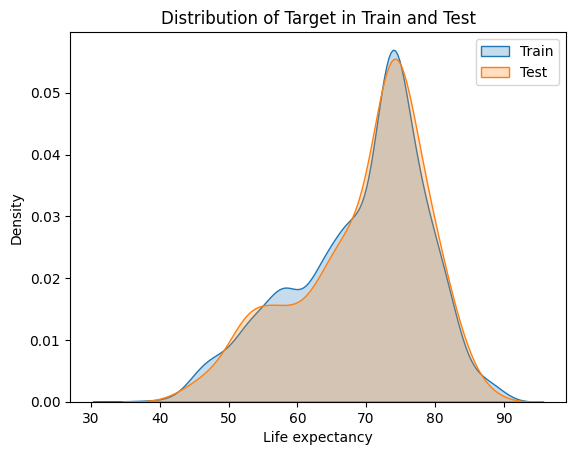

In [7]:
#Let's use a KDE plot to verify if they have the same order of distribution
target = 'Life expectancy'
sns.kdeplot(train[target], fill = True, label = 'Train')
sns.kdeplot(test[target], fill = True, label = 'Test')
plt.legend()
plt.title("Distribution of Target in Train and Test");

It seems the distribution of the target is similar for the train and the test

<h1>Data Understanding</h1>

In [8]:
#Size of train and test dataset

print("Shape of Entire Dataset is", df.shape)
print("Shape of Train Dataset is", train.shape)
print("Shape of Test Dataset is", test.shape)

Shape of Entire Dataset is (2928, 22)
Shape of Train Dataset is (2342, 22)
Shape of Test Dataset is (586, 22)


In [9]:
#view first and last five rows of our train to have a feel of our dataset

print("First Five Rows:")
display(train.head())

print("Last Five Rows:")
display(train.tail())

First Five Rows:


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2268,Serbia,2012,Developing,74.9,126.0,1,9.38,742.510971,97.0,0,58.3,1,93.0,9.89,91.0,0.1,5659.382400,719977.0,2.1,2.1,0.767,14.0
1680,Mauritius,2002,Developing,71.5,179.0,0,4.14,369.631710,88.0,0,26.4,0,88.0,4.24,88.0,0.1,3957.512960,124621.0,7.9,7.9,0.683,12.5
2785,United Republic of Tanzania,2008,Developing,56.2,376.0,92,3.44,0.000000,86.0,3413,19.6,138,89.0,4.21,86.0,7.4,NaN,NaN,7.3,7.3,NaN,NaN
2512,Sweden,2008,Developed,81.1,62.0,0,6.90,8105.590882,NaN,25,56.5,0,98.0,9.23,98.0,0.1,55746.842380,9219637.0,1.3,1.3,0.897,15.7
1090,Guinea-Bissau,2015,Developing,58.9,275.0,4,NaN,0.000000,87.0,153,26.3,6,87.0,NaN,87.0,3.2,596.871719,177526.0,7.1,7.0,0.421,9.2


Last Five Rows:


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1640,Malta,2009,Developed,82.0,63.0,0,7.38,335.518057,86.0,1,67.1,0,73.0,8.33,73.0,0.1,2675.582590,412477.0,0.8,0.7,0.815,14.4
1097,Guinea-Bissau,2008,Developing,55.6,297.0,5,2.64,28.301911,NaN,12,21.9,7,77.0,6.50,77.0,6.0,583.544562,148841.0,8.5,8.4,0.398,8.8
1132,Haiti,2005,Developing,65.0,29.0,17,5.57,38.109043,NaN,0,38.5,24,6.0,4.41,6.0,3.9,465.311876,926344.0,4.4,4.4,0.452,8.2
1296,Italy,2001,Developed,79.8,75.0,2,9.69,3.122230,95.0,0,55.7,3,96.0,8.11,93.0,0.1,24.819000,569741.0,0.5,0.5,0.828,14.9
862,Eritrea,2003,Developing,58.8,343.0,7,0.56,6.913998,91.0,376,13.3,10,95.0,3.50,93.0,1.9,232.794546,3738265.0,9.7,9.7,0.000,4.7


### About the Dataset (Columns)

Link to Dataset on Kaggle is given [here](https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who)

* Country: The country involved.
* Year: The year the survey was done
* Status: Developing or developed country
* Life expectancy: The life expectancy in age based on the other columns (This is the **target** variable)
* Adult mortality: Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)
* Infant Death: Number of Infant Deaths per 1000 population
* Alcohol: Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)
* Percentage Expenditure: Expenditure on health as a percentage of Gross Domestic Product per capita(%)
* Hepatitis B: Hepatitis B (HepB) immunization coverage among 1-year-olds (%)
* Measles: number of reported cases per 1000 population
* Thinness 1-19 years: The percentage of children and adolescents aged 1 to 19 who have a body mass index (BMI) below the threshold for age-appropriate nutrition
* Thinness 5 - 9 years: A more specific subset of the above, focusing on children aged 5 to 9. High thinness in this age group often indicates chronic malnutrition, which can impact immunity, growth, and survival rates.

#### Dataset Creator's Tasks:
* Does various predicting factors which has been chosen initially really affect the Life expectancy?
* What are the predicting variables actually affecting the life expectancy?
* Should a country having a lower life expectancy value(<65) increase its healthcare expenditure in order to improve its average lifespan?
* How does Infant and Adult mortality rates affect life expectancy?
* Does Life Expectancy has positive or negative correlation with eating habits, lifestyle, exercise, smoking, drinking alcohol etc.
* What is the impact of schooling on the lifespan of humans?
* Does Life Expectancy have positive or negative relationship with drinking alcohol?
* Do densely populated countries tend to have lower life expectancy?
* What is the impact of Immunization coverage on life Expectancy?

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2342 entries, 2268 to 862
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2342 non-null   object 
 1   Year                             2342 non-null   int64  
 2   Status                           2342 non-null   object 
 3   Life expectancy                  2342 non-null   float64
 4   Adult Mortality                  2342 non-null   float64
 5   infant deaths                    2342 non-null   int64  
 6   Alcohol                          2187 non-null   float64
 7   percentage expenditure           2342 non-null   float64
 8   Hepatitis B                      1898 non-null   float64
 9   Measles                          2342 non-null   int64  
 10  BMI                              2316 non-null   float64
 11  under-five deaths                2342 non-null   int64  
 12  Polio                  

In [11]:
#Check Datatypes and see if there are missing values

train_info = pd.DataFrame(
    {
        "Non-Null Count": train.count(),
        "Dtype":train.dtypes
    }
)

sorted_train_info = train_info.sort_values(by = "Non-Null Count", ascending = True)
sorted_train_info

,Non-Null Count,Dtype
Population,1831,float64
Hepatitis B,1898,float64
GDP,1995,float64
Total expenditure,2160,float64
Alcohol,2187,float64
Schooling,2212,float64
Income composition of resources,2212,float64
BMI,2316,float64
thinness 1-19 years,2316,float64
thinness 5-9 years,2316,float64


Majority of the Columns are of the Numerical Data type (float or int), except Status and Country which are of the object data type, for model building and evaluation, they will be encoded

In [12]:
#Columns with Only Null Values

cols_with_null = sorted_train_info[(sorted_train_info['Non-Null Count'] < train.shape[0]).values].index.tolist()
print("Columns with Missing values are: \n", cols_with_null)

Columns with Missing values are: 
 ['Population', 'Hepatitis B', 'GDP', 'Total expenditure', 'Alcohol', 'Schooling', 'Income composition of resources', 'BMI', 'thinness  1-19 years', 'thinness 5-9 years', 'Polio', 'Diphtheria']


# Data Cleaning

In [13]:
#check for duplicates
train.duplicated().sum()
#no duplicates found as we can see

np.int64(0)

#Inorder to handle the missing values.., let's do a rule of thumb.. if it's less than 5%, we can take out the rows

#See a list of what to do:
* 0–5% → Impute or drop rows

* 5–30% → Impute with mean/median/mode

* 30–60% → Impute if important, else consider dropping

* greater than 60% → Drop unless the column is critical or missingness itself is meaningful

In [14]:
round(train[cols_with_null].isnull().sum()/train.shape[0], 2)* 100

Population                         22.0
Hepatitis B                        19.0
GDP                                15.0
Total expenditure                   8.0
Alcohol                             7.0
Schooling                           6.0
Income composition of resources     6.0
BMI                                 1.0
thinness  1-19 years                1.0
thinness 5-9 years                  1.0
Polio                               1.0
Diphtheria                          1.0
dtype: float64

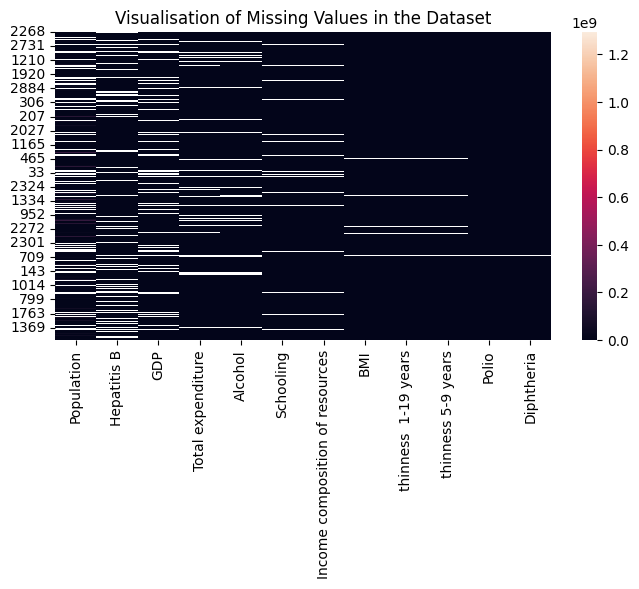

In [15]:
#Visualize missing Values

fig, ax = plt.subplots(figsize = (8, 4))
sns.heatmap(train[cols_with_null], ax = ax)
plt.title("Visualisation of Missing Values in the Dataset");

In [16]:
#since they are all numerical and are less than 30% ... they will be imputed with their median value
#i.e. Missing Values will be Median Imputed... since it's less prone to outliers

In [17]:
#impute missing values
si = SimpleImputer(strategy = 'median')
train2 = train.copy()
train2[cols_with_null] = si.fit_transform(train2[cols_with_null])

In [18]:
#verify if imputation has been done
print("The Missing Values in the Dataset is", train2.isnull().sum().sum())

The Missing Values in the Dataset is 0


# Exploratory Data Analysis

In [19]:
#our dataset is made up of two distinct data types, numerical and non numerical.. let's see the summary stats of the numerical
#by summary stats we refer to parameters like the mean, median and std

num_train = train2.select_dtypes("number")
summary_stats = num_train.agg(['mean', 'median', 'std'])
summary_stats

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
mean,2007.550811,69.149018,166.111870,30.203245,4.546473,724.095466,82.880871,2431.453032,38.107088,42.124680,82.428693,5.888941,82.006405,1.791503,6569.833897,9.613277e+06,4.856789,4.897950,0.629656,12.018147
median,2008.000000,72.000000,145.000000,3.000000,3.720000,65.268121,92.000000,17.000000,42.850000,4.000000,93.000000,5.700000,92.000000,0.100000,1732.857979,1.445958e+06,3.300000,3.300000,0.675500,12.300000
std,4.605192,9.577461,124.282313,113.818683,3.901973,1930.640716,23.043074,11436.680183,19.953950,156.118351,23.359582,2.413546,24.018921,5.183774,13276.449878,4.845776e+07,4.421027,4.519084,0.202825,3.254332


In [20]:
#On the side... let's see the parameters that have the largest variance.. and the highest trimmed variance okay?
num_train.var().sort_values().tail()

under-five deaths         2.437294e+04
percentage expenditure    3.727374e+06
Measles                   1.307977e+08
GDP                       1.762641e+08
Population                2.348155e+15
dtype: float64

In [21]:
#Because of outliers.., let's use the trimmed variance to see the highest variance columns when certain outliers are removed

num_train.apply(trimmed_var, limits = (0.1, 0.1)).sort_values().tail()

Adult Mortality           6.132660e+03
percentage expenditure    1.144719e+05
Measles                   3.915357e+05
GDP                       1.209226e+07
Population                1.546906e+13
dtype: float64

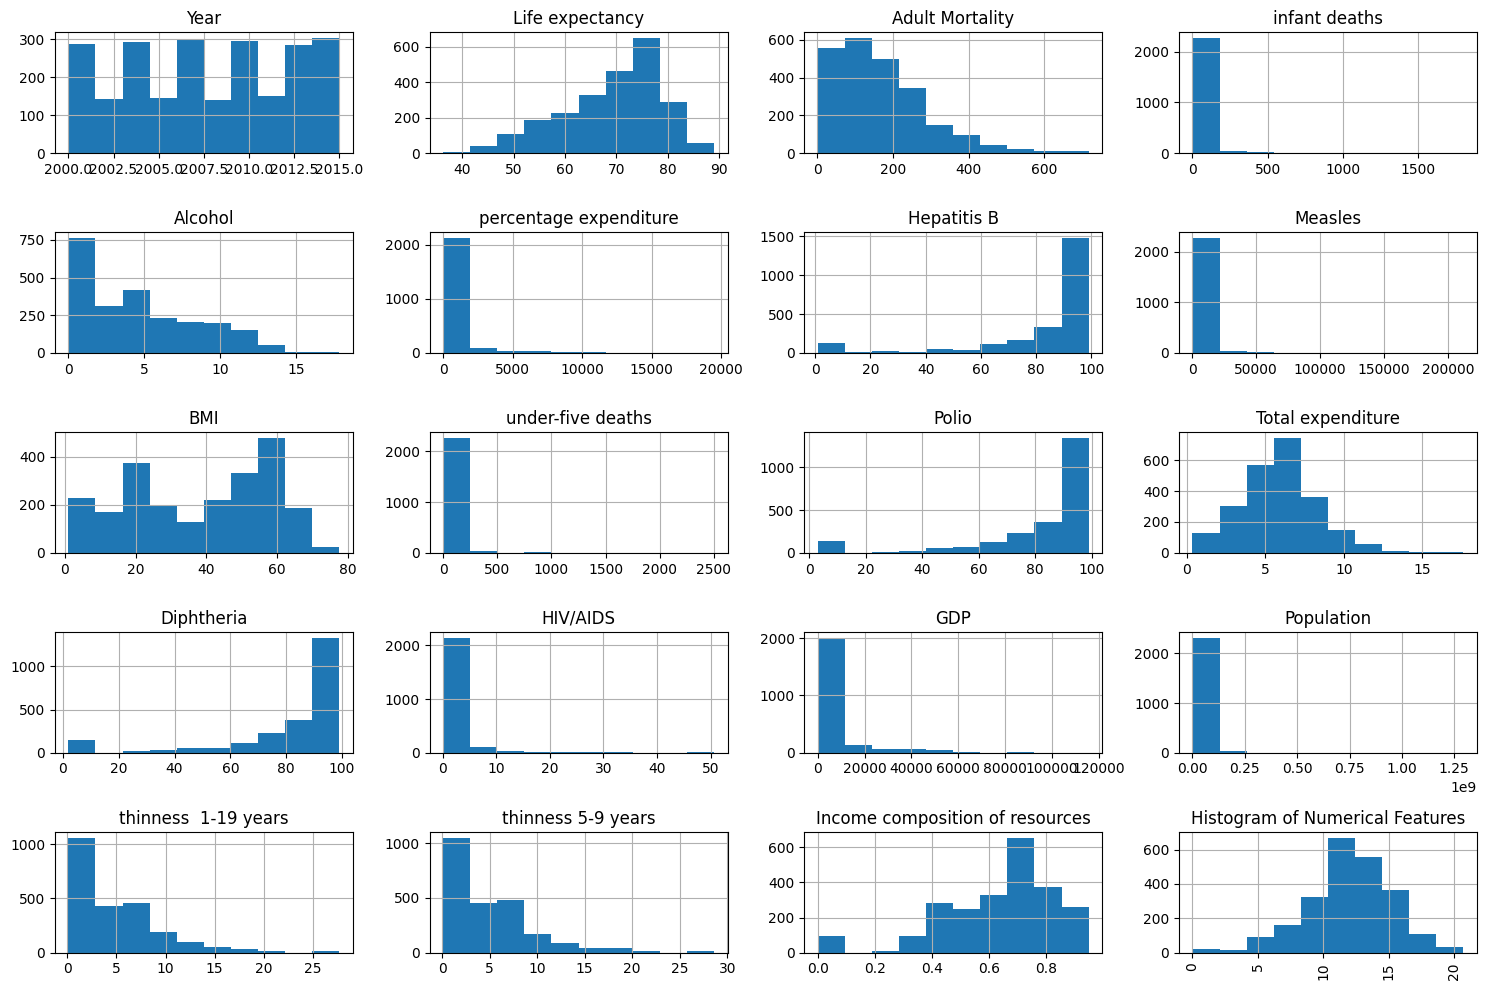

In [22]:
#Going by the std, some columns have high outliers..
#let's visualise that to have a visual understanding using histogram and boxplot
fig, ax = plt.subplots(figsize = (15, 10))
num_train.hist(ax = ax)
plt.title("Histogram of Numerical Features")
plt.xticks(rotation = 90)
plt.tight_layout();

In [23]:
#we will have to scale parameters so we have a balanced view of the boxplot
ssc = StandardScaler()
num_train_scaled = pd.DataFrame(ssc.fit_transform(num_train), columns = num_train.columns)
fig = px.box(num_train_scaled, title = "Boxplot of Scaled Numerical Features")
fig.update_layout(width=1000, height=600, xaxis_tickangle = 90, )
fig.show()

Our dataset contains lots of outliers.., we won't consider removing them as they may offer valuable information and the dataset is quite small. In order to handle this..we will use robust regression methods to reduce the significance of outliers

In [24]:
#let's do a little bit of analysis on the object columns
obj_train = train2.select_dtypes(include = "object")
obj_train.head()

,Country,Status
2268,Serbia,Developing
1680,Mauritius,Developing
2785,United Republic of Tanzania,Developing
2512,Sweden,Developed
1090,Guinea-Bissau,Developing


In [25]:
#Let's see the number of countries represented
obj_train.nunique()

Country    183
Status       2
dtype: int64

In [26]:
#Let's see the average life expectancy per country and rank based on the top five and least five
obj_train2 = obj_train.copy()
obj_train2['Life expectancy'] = train2['Life expectancy']

In [27]:
le_by_country = obj_train2.groupby('Country')['Life expectancy'].mean().sort_values()
print("Top Five Countries With Highest Life Expectancy:")
display(le_by_country.tail())
print("")
print("Top Five Countries With Lowest Life Expectancy:")
display(le_by_country.head)

fig = px.bar(x = le_by_country.tail().index, y = le_by_country.tail().values,
      title = "Top Five Countries with Highest Life Expectancy")
fig.update_layout(yaxis_title = "Life Expectancy")
fig.show()

fig = px.bar(x = le_by_country.head().index, y = le_by_country.head().values,
      title = "Top Five Countries with Lowest Life Expectancy")
fig.update_layout(yaxis_title = "Life Expectancy")
fig.show()

Top Five Countries With Highest Life Expectancy:


Country
Spain      82.390909
Iceland    82.443750
France     82.657143
Japan      82.660000
Italy      82.990909
Name: Life expectancy, dtype: float64


Top Five Countries With Lowest Life Expectancy:


<bound method NDFrame.head of Country
Sierra Leone                45.523077
Lesotho                     48.423077
Angola                      48.830769
Central African Republic    48.869231
Malawi                      49.613333
                              ...    
Spain                       82.390909
Iceland                     82.443750
France                      82.657143
Japan                       82.660000
Italy                       82.990909
Name: Life expectancy, Length: 183, dtype: float64>

In [28]:
#Let's also see the classification of life expectancy by status
le_by_status = obj_train2.groupby('Status')['Life expectancy'].agg(['mean'])
display(le_by_status)

# le_by_status.plot(kind = 'barh')
# plt.title("Life Expectancy by Status")
fig = px.bar(
    le_by_status,
    title = "Life Expectancy by Status"
)
fig.update_layout(yaxis_title = "Life Expectancy")
fig.show()

,mean
Status,
Developed,79.223457
Developing,67.042592


## Correlation Matrix for Numerical Features

In [29]:
#Correlation between Life Expectancy and Other Columns
corr_by_expectancy = num_train.corr()['Life expectancy'].sort_values(ascending = False)
display(corr_by_expectancy)
#Let's see a plot of the Top Five Most Correlated Features With Life Expectancy
fig = px.bar(corr_by_expectancy[1:6], x = corr_by_expectancy[1:6].index, y = corr_by_expectancy[1:6].values,
             title = "Top Five Most Correlated Features With Life Expectancy")
fig.update_layout(xaxis_title = "Features", yaxis_title = "Correlation Value")
fig.show()

Life expectancy                    1.000000
Schooling                          0.710993
Income composition of resources    0.684661
BMI                                0.561353
Diphtheria                         0.469653
Polio                              0.454772
GDP                                0.431409
Alcohol                            0.390584
percentage expenditure             0.387111
Total expenditure                  0.206915
Year                               0.172242
Hepatitis B                        0.164920
Population                        -0.026097
Measles                           -0.169950
infant deaths                     -0.209330
under-five deaths                 -0.235214
thinness 5-9 years                -0.468471
thinness  1-19 years              -0.474983
HIV/AIDS                          -0.557158
Adult Mortality                   -0.695271
Name: Life expectancy, dtype: float64

In [30]:
#Let's check for multicolinearity amongst the numerical features

fig = px.imshow(num_train.drop(columns = 'Life expectancy').corr(), title = "Correlation amongst Numerical Features")
fig.update_layout(width = 700, height = 700)

Some features are highly correlated with each other like :
* infant deaths and under-five deaths. (0.996) - pick under five deaths (-0.228)
* Also, features like Income composition of resources is highly correlated with Schooling (0.8) - pick schooling (0.707)
* GDP is highly correlated with percentage expenditure. (0.895) - pick GDP (0.42)
* thinness 1-19 years is highly correlated with thinness 5-9 years (0.93) - pick thinness 1-19 years (-0.4656)

i.e. Columns to Drop are: Infant deaths, Income Composition of resources, percentage expenditure, thinness 5-9 years

In [31]:
#Let's see how important each feature are using mutual info regression
#But, before we do this... we convert the categorical features to numeric features

In [32]:
oe = OrdinalEncoder()
train3 = train2.copy()
cat_features = train2.select_dtypes("object").columns
train3[cat_features] = oe.fit_transform(train3[cat_features])

In [33]:
#let's use mutual info regression now
X = train3.drop(columns = 'Life expectancy')
y = train3['Life expectancy']

mi_scores = mutual_info_regression(X, y)

mi_scores_df = pd.Series(mi_scores, index = X.columns).sort_values(ascending = False)
display(mi_scores_df)

#Let's see a plot and understand it below:

fig = px.bar(mi_scores_df, x = mi_scores_df.index, y = mi_scores_df.values, 
       title = "Importance of Features using Mutual Info Regression")
fig.update_layout(xaxis_title = "Features", yaxis_title = "MI Scores")
fig.show()

Adult Mortality                    1.268109
Income composition of resources    0.927799
thinness 5-9 years                 0.777112
thinness  1-19 years               0.755610
Schooling                          0.677358
BMI                                0.596463
Country                            0.555094
HIV/AIDS                           0.534487
under-five deaths                  0.428502
infant deaths                      0.400495
GDP                                0.351321
Alcohol                            0.327201
percentage expenditure             0.309457
Polio                              0.308814
Diphtheria                         0.308055
Total expenditure                  0.253908
Hepatitis B                        0.197451
Status                             0.192792
Population                         0.146960
Measles                            0.120752
Year                               0.073780
dtype: float64

# Feature Engineering

In [34]:
train.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

In [35]:
#We will encode the categorical features.. (Country and Status), which we did previously.
#No need to scale/normalize.., since we'd be using a model that is robust to outliers
#Let's drop some columns okay.. cols_to_drop = ['thinness 5-9 years', 'infant deaths', 'percentage expenditure']
cols_to_drop = ['thinness 5-9 years', 'infant deaths', 'percentage expenditure']
train2 = train.drop(columns = cols_to_drop)
#let's drop same for the test
test2 = test.drop(columns = cols_to_drop)
#We wont be creating new features

# Model Building

In [36]:
#Let's split our dataset into Features and target

X = train2.drop(columns = 'Life expectancy')
y = train2['Life expectancy']

In [37]:
#Let's create a pipeline to handle the categorical and numerical variables separately

#for the numerical variables.., all we need to do is fill in the missing values with the median value
#for the categorical veriables, all we need to do is label encode them..., I think that's pretty much it

num_pipeline = make_pipeline(
    SimpleImputer(strategy = 'median')
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    OrdinalEncoder()
)

In [38]:
#This preprocessing step will be applied to both the train and test alright

preprocessor = ColumnTransformer(
    [
    ('num', num_pipeline, X.select_dtypes("number").columns),
    ('cat', cat_pipeline, X.select_dtypes("object").columns),
    ],
    remainder = 'passthrough'
)

In [39]:
#Let's Preprocess our train and test

train_p = pd.DataFrame(preprocessor.fit_transform(X), columns = preprocessor.get_feature_names_out())
test_p = pd.DataFrame(preprocessor.transform(test.drop(columns = 'Life expectancy')), columns = preprocessor.get_feature_names_out())

# Baseline Models

In [40]:
#Before we continue.., let's split our train.. into train and validation
X_t, X_v, y_t, y_v = train_test_split(train_p, y, test_size = 0.2, random_state = 42)

In [41]:
#using mean_squared_error as the evaluation metric.., let's assume a dummy model 
y_pred = [y_t.mean()]*y_t.shape[0]

In [42]:
root_mean_squared_error(y_pred, y_t)

9.597071120776729

## Evaluating using LinearRegression

In [43]:
le = LinearRegression()
le.fit(X_t, y_t)
train_mse = root_mean_squared_error(le.predict(X_t), y_t)
print("Train RMSE is", train_mse)
val_mse = root_mean_squared_error(le.predict(X_v), y_v)
print("Validation RMSE is", val_mse)

Train RMSE is 4.137024742362317
Validation RMSE is 4.235140599180066


## Evaluating using RandomForestRegressor

In [44]:
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_t, y_t)
train_mse = root_mean_squared_error(rf.predict(X_t), y_t)
print("Train RMSE is", train_mse)
val_mse = root_mean_squared_error(rf.predict(X_v), y_v)
print("Validation RMSE is", val_mse)

Train RMSE is 0.7209880489193039
Validation RMSE is 2.0543829623701537


It seems our model is overfitting..., let's adjust the max depth so that our model doesn't overfit

In [45]:
rmse = make_scorer(root_mean_squared_error)

results = cross_val_score(rf, train_p, y, scoring = rmse, cv = 10)
results

array([2.07000174, 1.63829134, 1.84788364, 2.15405361, 1.90260509,
       1.91754812, 1.88109046, 1.76407642, 1.64559795, 1.8745469 ])

In [46]:
print(round(np.mean(results),3), "±", round(np.std(results), 3))

1.87 ± 0.155


In [47]:
#Let's get the best max depth in order to avoid overfitting

depths = range(1, 11)
train_errors = []
val_errors = []

for d in depths:
    model = RandomForestRegressor(max_depth = d, random_state = 42)
    model.fit(X_t, y_t)
    y_train_pred = model.predict(X_t)
    y_val_pred = model.predict(X_v)
    #Let's get the errors
    train_rmse = root_mean_squared_error(y_train_pred, y_t)
    val_rmse = root_mean_squared_error(y_val_pred, y_v)
    #Let's append the errors
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

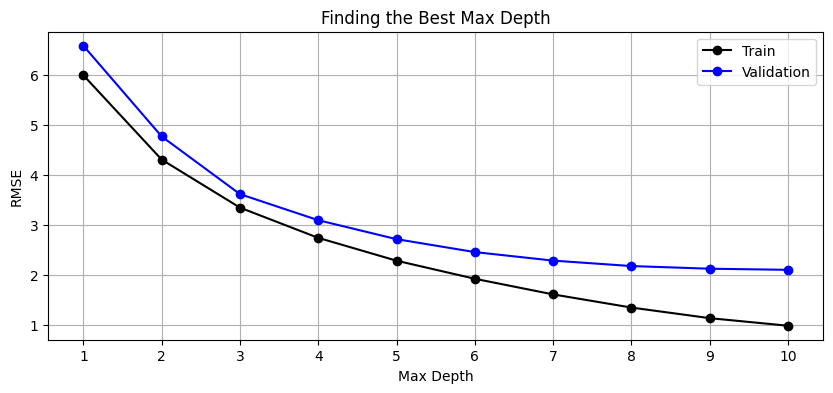

In [48]:
#let's see a line plot alright
fig, ax = plt.subplots(figsize = (10, 4))
plt.plot(depths, train_errors, marker = 'o', color = 'k', label = 'Train')
plt.plot(depths, val_errors, marker = 'o', color = 'blue', label = 'Validation')
plt.xticks(depths)
plt.title("Finding the Best Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("RMSE")
plt.grid()
plt.legend()
plt.show()

Looking at the plot, the max depth, that gives almost similar values for both Train and Validation is 3 and 4... we choose 4

In [49]:
#let's see it in figures
rf = RandomForestRegressor(max_depth = 4, random_state = 42)
rf.fit(X_t, y_t)
train_mse = root_mean_squared_error(rf.predict(X_t), y_t)
print("Train RMSE is", train_mse)
val_mse = root_mean_squared_error(rf.predict(X_v), y_v)
print("Validation RMSE is", val_mse)

#we can see that.. it gives a better generalization between the train and validation

Train RMSE is 2.740756236573022
Validation RMSE is 3.093283823924373


In [50]:
#using max depth of 4..., let's get what we need

best_rf = RandomForestRegressor(max_depth = 4, random_state = 42)
best_results = cross_val_score(best_rf, train_p, y, scoring = rmse, cv = 10)
best_results

array([3.01426754, 2.7346074 , 3.14491412, 3.14319328, 3.21090336,
       2.89197345, 3.00425109, 3.03364748, 2.84935467, 3.0280251 ])

In [51]:
print(round(np.mean(best_results),3), "±", round(np.std(best_results), 3))

3.006 ± 0.139


## Hyperparameter Tuning

In [52]:
#let's define some custom hyperparameters for tuning

param_grid = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [4, 8, 12],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(max_depth = 4, random_state = 42)

grid_search_rf = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    cv = 5,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1,
    verbose = 1
)

In [53]:
grid_search_rf.fit(X_t, y_t)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'bootstrap': [True, False], 'max_features': ['auto', 'sqrt', ...], 'min_samples_leaf': [4, 8, ...], 'min_samples_split': [5, 10, ...], ...}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [54]:
grid_search_rf.best_params_

{'bootstrap': True,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 15,
 'n_estimators': 300}

In [55]:
rf = RandomForestRegressor(random_state = 42, **grid_search_rf.best_params_)
rf.fit(X_t, y_t)
train_mse = root_mean_squared_error(rf.predict(X_t), y_t)
print("Train RMSE is", train_mse)
val_mse = root_mean_squared_error(rf.predict(X_v), y_v)
print("Validation RMSE is", val_mse)

Train RMSE is 1.659243339143365
Validation RMSE is 2.3361232349106085


In [56]:
#let's do the log target approach
rf = RandomForestRegressor(random_state = 42, max_depth = 4)
rf.fit(X_t, np.log1p(y_t))
train_preds_log = rf.predict(X_t)
val_preds_log = rf.predict(X_v)
train_preds_exp = np.expm1(train_preds_log)
val_preds_exp = np.expm1(val_preds_log)
train_mse = root_mean_squared_error(train_preds_exp, y_t)
print("Train RMSE is", train_mse)
val_mse = root_mean_squared_error(val_preds_exp, y_v)
print("Validation RMSE is", val_mse)

Train RMSE is 2.774296906766033
Validation RMSE is 3.1541659645623294


## Evaluating Using Support Vector Machine

In [57]:
ssc = StandardScaler()
X_t_scaled = ssc.fit_transform(X_t)
X_v_scaled = ssc.transform(X_v)

In [58]:
#let's see it in figures
svr = SVR()
svr.fit(X_t_scaled, y_t)
train_mse = root_mean_squared_error(svr.predict(X_t_scaled), y_t)
print("Train RMSE is", train_mse)
val_mse = root_mean_squared_error(svr.predict(X_v_scaled), y_v)
print("Validation RMSE is", val_mse)

#we can see that.. it gives a better generalization between the train and validation

Train RMSE is 3.613431094887326
Validation RMSE is 3.837876193441253


In [59]:
#Hyperparameter tuning for SVR

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['linear', 'rbf', 'poly']
}

svr = SVR()
grid_search_svr = GridSearchCV(svr, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search_svr.fit(X_t_scaled, y_t)

,estimator,SVR()
,param_grid,"{'C': [0.1, 1, ...], 'epsilon': [0.01, 0.1, ...], 'kernel': ['linear', 'rbf', ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,kernel,'rbf'


In [60]:
grid_search_svr.best_score_

np.float64(-2.750480150958636)

In [61]:
#let's see it in code
svr = SVR(**grid_search_svr.best_params_)
svr.fit(X_t_scaled, y_t)
train_mse = root_mean_squared_error(svr.predict(X_t_scaled), y_t)
print("Train RMSE is", train_mse)
val_mse = root_mean_squared_error(svr.predict(X_v_scaled), y_v)
print("Validation RMSE is", val_mse)

#we can see that.. it gives a better generalization between the train and validation

Train RMSE is 2.033170933334499
Validation RMSE is 2.72324532280605


## Evaluating Using Ensemble Methods

In [62]:
#lt's try a voting regressor

vr = VotingRegressor(
    estimators = [('lr', LinearRegression()), ('svr', SVR(**grid_search_svr.best_params_)), 
                  ('rf', RandomForestRegressor(max_depth = 4, random_state = 42, **grid_search_rf.best_params_))],
)

In [63]:
#let's see it in code
voting = vr
voting.fit(X_t_scaled, y_t)
train_mse = root_mean_squared_error(voting.predict(X_t_scaled), y_t)
print("Train RMSE is", train_mse)
val_mse = root_mean_squared_error(voting.predict(X_v_scaled), y_v)
print("Validation RMSE is", val_mse)

#we can see that.. it gives a better generalization between the train and validation

Train RMSE is 2.7266147607975957
Validation RMSE is 3.045257352976301


In [64]:
#this model generalizes well, but now, let's see how it performs across multiple folds
#before we use this.., we must scale train_p, first
ssc = StandardScaler()
train_p_scaled = ssc.fit_transform(train_p)
best_results = cross_val_score(voting, train_p_scaled, y, scoring = rmse, cv = 10)
display(best_results)
print(round(np.mean(best_results),3), "±", round(np.std(best_results), 3))

array([3.2253183 , 2.57335178, 2.95082876, 3.31267681, 3.08557399,
       2.69764565, 2.99610146, 3.04890134, 2.66462184, 3.13004322])

2.969 ± 0.235


In [65]:
#Finally, our best model to use was our RandomForestModel of random_state = 42., since it had a better cross validation score

# Making Predictions

In [66]:
model = RandomForestRegressor(random_state = 42)
model.fit(train_p, y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [67]:
test_predictions = model.predict(test_p)

In [68]:
rmse_test = root_mean_squared_error(test_predictions, test['Life expectancy'])
rmse_test

1.6596441880891273

# Communicating Results

In [69]:
importances =  model.feature_importances_
fi_df = pd.Series(importances, index = test_p.columns).sort_values(ascending = False)
display(fi_df)

#Let's display this with a plot alright

fig = px.bar(
    fi_df,
    x = fi_df.index,
    y = fi_df.values,
    title = "Feature Importances with Random Forest Regressor"
)
fig.update_layout(xaxis_title = "Features", yaxis_title = "Feautre Importance", height = 400)
fig.show()

num__HIV/AIDS                           0.596126
num__Income composition of resources    0.173157
num__Adult Mortality                    0.125798
num__under-five deaths                  0.019068
num__BMI                                0.017996
num__thinness  1-19 years               0.011760
num__Schooling                          0.010107
num__Alcohol                            0.007691
num__Year                               0.007270
cat__Country                            0.005112
num__Total expenditure                  0.004836
num__Polio                              0.004576
num__GDP                                0.004130
num__Measles                            0.003865
num__Population                         0.003594
num__Diphtheria                         0.002771
num__Hepatitis B                        0.001891
cat__Status                             0.000251
dtype: float64

Communication and Final Thoughts: We used two complementary techniques — a model-based approach (Random Forest) and a statistical one (Mutual Information) — to identify the most influential factors in predicting life expectancy. The overlap and consistency between the methods give us confidence in these top five. They reflect a mix of economic, educational, and health-related drivers that policy or investment can directly influence.
The top five are:
* Adult Mortality
* Income Composition of Resources
* HIV/AIDS
* Schooling
* Thinness 1 - 19 years

# Interactive Dashboard with Jupyter

In [70]:
feats_to_use = fi_df.head().index.tolist() #top five most important features from our model (RandomForestRegressor)
feats_to_use

['num__HIV/AIDS',
 'num__Income composition of resources',
 'num__Adult Mortality',
 'num__under-five deaths',
 'num__BMI']

In [71]:
#we will train our model for the purpose of this dashboard with the top five features
small_model = RandomForestRegressor(random_state = 42)
small_model.fit(train_p[feats_to_use], y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [72]:
#let's take a peak at the original train to see how the original columns look, so we can establish min max values
train.head(2)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2268,Serbia,2012,Developing,74.9,126.0,1,9.38,742.510971,97.0,0,58.3,1,93.0,9.89,91.0,0.1,5659.38240,719977.0,2.1,2.1,0.767,14.0
1680,Mauritius,2002,Developing,71.5,179.0,0,4.14,369.631710,88.0,0,26.4,0,88.0,4.24,88.0,0.1,3957.51296,124621.0,7.9,7.9,0.683,12.5


In [73]:
#let's write a prediction function
def le_predict(hiv_aids = train['HIV/AIDS'].mean(), income = train['Income composition of resources'].mean(), 
               adult_mortality = train['Adult Mortality'].mean(), deaths = train['under-five deaths'].mean(), 
               bmi = train['BMI'].mean()):
    #defining parameters okay
    input_data = pd.DataFrame([
        {
            'num__HIV/AIDS':hiv_aids,
            'num__Income composition of resources': income,
            'num__Adult Mortality': adult_mortality,
            'num__under-five deaths':deaths,
            'num__BMI':bmi
        }
    ])
    #let's make a prediction off this
    prediction = small_model.predict(input_data)[0]
    # print(f"Predicted Life Expectancy is:", round(prediction, 2))
    return f"Life expectancy: {round(prediction, 2)}"

In [ ]:
widgets.interact(le_predict, hiv_aids = (train['HIV/AIDS'].min(), train['HIV/AIDS'].max()), 
                 income = (train['Income composition of resources'].min(), train['Income composition of resources'].max()), 
                 adult_mortality = (train['Adult Mortality'].min(), train['Adult Mortality'].max()), 
                 deaths = (train['under-five deaths'].min(), train['under-five deaths'].max()), 
                 bmi = (train['BMI'].min(), train['BMI'].max()));